# Coursework: Age regression from brain MRI

Predicting the age of patient from a brain MRI scan can have diagnostic value for a number of diseases that may cause structural changes and potential damage to the brain. A discrepancy between the predicted age and the real, chronological age of a patient might indicate the presence of disease. This requires an accurate predictor of brain age which may be learned from a set of healthy reference subjects, given their brain MRI data and their actual age.

The objective for the coursework is to implement different supervised learning approaches for age regression from brain MRI. We provided data from a total of 652 healthy subjects, that is split into different development sets and a held-out test set on which you will evaluate your final prediction accuracy.

Each approach will require a processing pipeline with different components that you will need to implement using methods that were discussed in the lectures and tutorials. There are three dedicated parts in the Jupyter notebook for each approach which contain some detailed instructions and some helper code.

You may find some useful ideas and implementations in the tutorial notebooks. Once you have implemented all approaches and obtained results from your experiments, we ask you to write a short summary report. The reports should contain a short introduction, description of each of your methods and the individual processing steps, your results with a brief discussion. The report should also include some figures and plots to support your findings.

#### Read the text descriptions and the provided code cells carefully and look out for the cells marked with 'TASK' and 'ADD YOUR CODE HERE'.

### Getting started and familiarise ourselves with the data

The following cells provide some helper functions to load the data, and provide some overview and visualisation of the statistics over the total population of 652 subjects. The data will be split into different subsets to be used for different parts of the coursework. There is a set of 52 subjects to be used in part A to develop an image segmentation method (47 for training, 5 for validation). We then use 500 subjects for training and cross-validation of age regression approaches in part A, B and C. A remaining set of 100 subjects is used to test the final age prediction accuracy and will be made available towards the end of the coursework.

### Running on Colab or Azure

In [1]:
! pip install SimpleITK==1.2.2 
! wget https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/brainage-data.zip
! wget https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/meta_data_reg_test.csv
! unzip brainage-data.zip
! pip install scikit-learn
! mv meta_data_reg_test.csv data/brain_age/meta/

# data directory
data_dir = 'data/brain_age/'

     |████████████████████████████████| 42.5MB 72kB/s 
--2020-02-28 18:23:54--  https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/brainage-data.zip
Resolving www.doc.ic.ac.uk (www.doc.ic.ac.uk)... 146.169.13.6
Connecting to www.doc.ic.ac.uk (www.doc.ic.ac.uk)|146.169.13.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 900391705 (859M) [application/zip]
Saving to: ‘brainage-data.zip’

brainage-data.zip   100%[===================>] 858.68M   225MB/s    in 4.2s    

2020-02-28 18:23:58 (207 MB/s) - ‘brainage-data.zip’ saved [900391705/900391705]

--2020-02-28 18:24:00--  https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/meta_data_reg_test.csv
Resolving www.doc.ic.ac.uk (www.doc.ic.ac.uk)... 146.169.13.6
Connecting to www.doc.ic.ac.uk (www.doc.ic.ac.uk)|146.169.13.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2520 (2.5K) [text/csv]
Saving to: ‘meta_data_reg_test.csv’

meta_data_reg_test. 100%[===================>]   2.46K  --

### Running on DoC lab machines

In [0]:
# data directory
data_dir = '/vol/lab/course/416/data/brain_age/'

Let's start by loading the meta data of the entire population, that is the data containing information about the subject IDs, their age, and gender.

In [2]:
# Read the meta data using pandas
import pandas as pd

meta_data_all = pd.read_csv(data_dir + 'meta/meta_data_all.csv')
meta_data_all.head() # show the first five data entries

,subject_id,age,gender_code,gender_text
0,CC110033,24,1,MALE
1,CC110037,18,1,MALE
2,CC110045,24,2,FEMALE
3,CC110056,22,2,FEMALE
4,CC110062,20,1,MALE


Let's have a look at some population statistics.

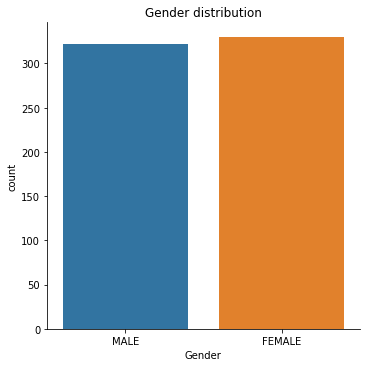

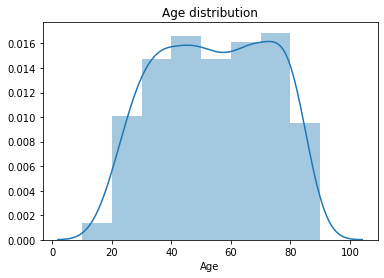

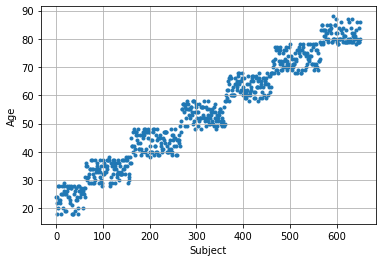

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

meta_data = meta_data_all

sns.catplot(x="gender_text", data=meta_data, kind="count")
plt.title('Gender distribution')
plt.xlabel('Gender')
plt.show()

sns.distplot(meta_data['age'], bins=[10,20,30,40,50,60,70,80,90])
plt.title('Age distribution')
plt.xlabel('Age')
plt.show()

plt.scatter(range(len(meta_data['age'])),meta_data['age'], marker='.')
plt.grid()
plt.xlabel('Subject')
plt.ylabel('Age')
plt.show()

### Set up a simple medical image viewer and import SimpleITK

In [0]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import display

# Calculate parameters low and high from window and level
def wl_to_lh(window, level):
    low = level - window/2
    high = level + window/2
    return low,high

def display_image(img, x=None, y=None, z=None, window=None, level=None, colormap='gray', crosshair=False):
    # Convert SimpleITK image to NumPy array
    img_array = sitk.GetArrayFromImage(img)
    
    # Get image dimensions in millimetres
    size = img.GetSize()
    spacing = img.GetSpacing()
    width  = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth  = size[2] * spacing[2]
    
    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)
    
    if window is None:
        window = np.max(img_array) - np.min(img_array)
    
    if level is None:
        level = window / 2 + np.min(img_array)
    
    low,high = wl_to_lh(window,level)

    # Display the orthogonal slices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

    ax1.imshow(img_array[z,:,:], cmap=colormap, clim=(low, high), extent=(0, width, height, 0))
    ax2.imshow(img_array[:,y,:], origin='lower', cmap=colormap, clim=(low, high), extent=(0, width,  0, depth))
    ax3.imshow(img_array[:,:,x], origin='lower', cmap=colormap, clim=(low, high), extent=(0, height, 0, depth))

    # Additionally display crosshairs
    if crosshair:
        ax1.axhline(y * spacing[1], lw=1)
        ax1.axvline(x * spacing[0], lw=1)
        ax2.axhline(z * spacing[2], lw=1)
        ax2.axvline(x * spacing[0], lw=1)
        ax3.axhline(z * spacing[2], lw=1)
        ax3.axvline(y * spacing[1], lw=1)

    plt.show()
    
def interactive_view(img):
    size = img.GetSize() 
    img_array = sitk.GetArrayFromImage(img)
    interact(display_image,img=fixed(img),
             x=(0, size[0] - 1),
             y=(0, size[1] - 1),
             z=(0, size[2] - 1),
             window=(0,np.max(img_array) - np.min(img_array)),
             level=(np.min(img_array),np.max(img_array)));

### Imaging data

Let's check out the imaging data that is available for each subject. This cell also shows how to retrieve data given a particular subject ID from the meta data.

Imaging data of subject CC110033 with age 24

MR Image (used in part A)


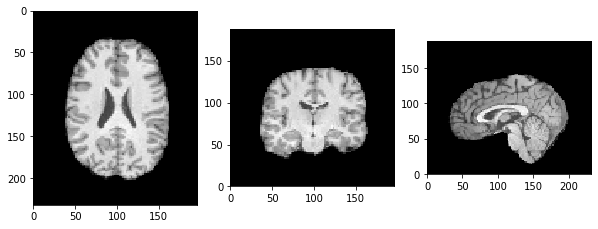

Brain mask (used in part A)


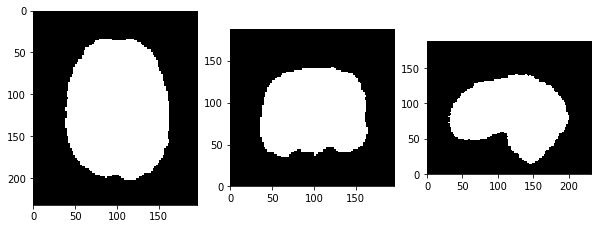

Spatially normalised grey matter maps (used in part B and C)


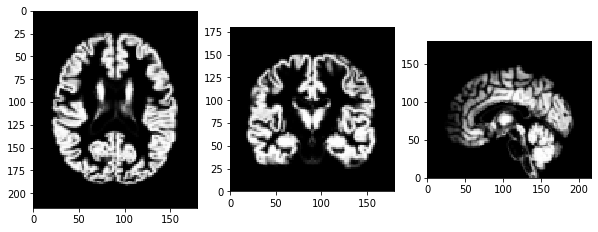

In [5]:
# Subject with index 0
def print_with_ID(id):
  ID = meta_data['subject_id'][id]
  age = meta_data['age'][id]

  # Image
  image_filename = data_dir + 'images/sub-' + ID + '_T1w_unbiased.nii.gz'
  img = sitk.ReadImage(image_filename)

  # Mask
  mask_filename = data_dir + 'masks/sub-' + ID + '_T1w_brain_mask.nii.gz'
  msk = sitk.ReadImage(mask_filename)

  # Grey matter map
  gm_filename = data_dir + 'greymatter/wc1sub-' + ID + '_T1w.nii.gz'
  gm = sitk.ReadImage(gm_filename)

  print('Imaging data of subject ' + ID + ' with age ' + str(age))

  print('\nMR Image (used in part A)')
  display_image(img, window=400, level=200)

  print('Brain mask (used in part A)')
  display_image(msk)

  print('Spatially normalised grey matter maps (used in part B and C)')
  display_image(gm)

print_with_ID(0)

## Part A: Volume-based regression using brain structure segmentation

The first approach aims to regress the age of a subject using the volumes of brain tissues as features. The brain structures include grey matter (GM), white matter (WM), and cerebrospinal fluid (CSF). It is known that with increasing age the ventricles enlarge (filled with CSF), while it is assumed that grey and white matter volume may decrease over time. However, as overall brain volume varies across individuals, taking the absolute volumes of tissues might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume. To this end, a four-class (GM, WM, CSF, and background) brain segmentation needs to be implemented which will be trained using a total of 52 subjects (47 for training, 5 for validation). The segmentation method is then applied to the remaining 600 brain scans which will be used to train and test the age regression. Brain masks are provided which have been generated with a state-of-the-art neuroimaging brain extraction tool.

Different regression techniques should be explored, and it might be beneficial to investigate what the best set of features is for this task. Are all volume features equally useful, or is it even better to combine some of them and create new features. How does a simple linear regression perform compared to a model with higher order polynomials? Do you need regularisation? How about other regression methods such as regression trees, SVMs or neural networks? The accuracy of different methods should be evaluated using two-fold cross-validation on the set of 500 subjects, and average age prediction accuracy should be compared and reported appropriately. The final prediction accuracy will be evaluated on a hold-out set of 100 subjects.

*Note:* For part A, only the MR images and the brain masks should be used from the imaging data. The spatially normalised grey matter maps are used in part B and C only. If you struggle with task A-1, you can continue with A-2 using the provided reference segmentations in subfolder `segs_refs`.

### TASK A-1: Brain tissue segmentation

Implement a CNN model for brain tissue segmentation which can provide segmentations of GM, WM, and CSF. For this task (and only for this task), we provide a subset of 52 subjects which are split into 47 images for training and 5 for validation. The template code below has the data handling and main training routines already implemented, so you can focus on implementing a suitable CNN model. A simple model is provided, but this won't perform very well.

Once your model is trained and you are happy with the results on the validation data you should apply it to the 500 subjects later used for training the age regressor. We provide reference segmentations in a subfolder `segs_refs` for all subjects. Calculate Dice similarity coefficients per tissue when comparing your predicted segmentations to the reference segmentations. Summarise the statistics of the 500 Dice scores for each tissue class in [box-and-whisker-plots](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.boxplot.html).

*Note:* Implementing a full-fledged machine learning pipeline with training and testing procedures in Jupyter notebooks is a bit cumbersome and a pain to debug. Also, running bigger training tasks can be unstable. The code below should work as is on your VM. However, if you want to get a bit more serious about implementing an advanced CNN approach for image segmentation, you may want to move code into separate Python scripts and run these from the terminal.

#### Imports

In [0]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn import metrics

#### Data Helpers

In [0]:
def zero_mean_unit_var(image, mask):
    """Normalizes an image to zero mean and unit variance."""

    img_array = sitk.GetArrayFromImage(image)
    img_array = img_array.astype(np.float32)

    msk_array = sitk.GetArrayFromImage(mask)

    mean = np.mean(img_array[msk_array>0])
    std = np.std(img_array[msk_array>0])

    if std > 0:
        img_array = (img_array - mean) / std
        img_array[msk_array==0] = 0

    image_normalised = sitk.GetImageFromArray(img_array)
    image_normalised.CopyInformation(image)

    return image_normalised


def resample_image(image, out_spacing=(1.0, 1.0, 1.0), out_size=None, is_label=False, pad_value=0):
    """Resamples an image to given element spacing and output size."""

    original_spacing = np.array(image.GetSpacing())
    original_size = np.array(image.GetSize())

    if out_size is None:
        out_size = np.round(np.array(original_size * original_spacing / np.array(out_spacing))).astype(int)
    else:
        out_size = np.array(out_size)

    original_direction = np.array(image.GetDirection()).reshape(len(original_spacing),-1)
    original_center = (np.array(original_size, dtype=float) - 1.0) / 2.0 * original_spacing
    out_center = (np.array(out_size, dtype=float) - 1.0) / 2.0 * np.array(out_spacing)

    original_center = np.matmul(original_direction, original_center)
    out_center = np.matmul(original_direction, out_center)
    out_origin = np.array(image.GetOrigin()) + (original_center - out_center)

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size.tolist())
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(out_origin.tolist())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(pad_value)

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(image)


class ImageSegmentationDataset(Dataset):
    """Dataset for image segmentation."""

    def __init__(self, file_list_img, file_list_seg, file_list_msk, img_spacing, img_size):
        self.samples = []
        self.img_names = []
        self.seg_names = []
        for idx, _ in enumerate(tqdm(range(len(file_list_img)), desc='Loading Data')):
            img_path = file_list_img[idx]
            seg_path = file_list_seg[idx]
            msk_path = file_list_msk[idx]

            img = sitk.ReadImage(img_path, sitk.sitkFloat32)

            seg = sitk.ReadImage(seg_path, sitk.sitkInt64)

            msk = sitk.ReadImage(msk_path, sitk.sitkUInt8)

            #pre=processing
            img = zero_mean_unit_var(img, msk)
            img = resample_image(img, img_spacing, img_size, is_label=False)
            seg = resample_image(seg, img_spacing, img_size, is_label=True)
            msk = resample_image(msk, img_spacing, img_size, is_label=True)

            sample = {'img': img, 'seg': seg, 'msk': msk}

            self.samples.append(sample)
            self.img_names.append(os.path.basename(img_path))
            self.seg_names.append(os.path.basename(seg_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        sample = self.samples[item]

        image = torch.from_numpy(sitk.GetArrayFromImage(sample['img'])).unsqueeze(0)
        seg = torch.from_numpy(sitk.GetArrayFromImage(sample['seg'])).unsqueeze(0)
        msk = torch.from_numpy(sitk.GetArrayFromImage(sample['msk'])).unsqueeze(0)

        return {'img': image, 'seg': seg, 'msk': msk}

    def get_sample(self, item):
        return self.samples[item]

    def get_img_name(self, item):
        return self.img_names[item]

    def get_seg_name(self, item):
        return self.seg_names[item]


#### Check that the GPU is up and running

In [8]:
cuda_dev = '0' #GPU device 0 (can be changed if multiple GPUs are available)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:" + cuda_dev if use_cuda else "cpu")

print('Device: ' + str(device))
if use_cuda:
    print('GPU: ' + str(torch.cuda.get_device_name(int(cuda_dev))))        

Device: cuda:0
GPU: Tesla T4


#### Config and hyper-parameters

Here we set some default hyper-parameters and a starting configuration for the image resolution and others.

**TASK: This needs to be revisited to optimise these values. In particular, you may want to run your final model on higher resolution images.**

In [0]:
rnd_seed = 42 #fixed random seed

img_size = [94, 116, 98]
img_spacing = [2, 2, 2]

num_epochs = 100
learning_rate = 0.001
batch_size = 2
val_interval = 10

num_classes = 4

out_dir = './output'

# Create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

#### Loading and pre-processing of training and validation data

In [0]:
meta_data_seg_train = pd.read_csv(data_dir + 'meta/meta_data_seg_train.csv')
ids_seg_train = list(meta_data_seg_train['subject_id'])
files_seg_img_train = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_train]
files_seg_seg_train = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_train]
files_seg_msk_train = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_train]

meta_data_seg_val = pd.read_csv(data_dir + 'meta/meta_data_seg_val.csv')
ids_seg_val = list(meta_data_seg_val['subject_id'])
files_seg_img_val = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_val]
files_seg_seg_val = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_val]
files_seg_msk_val = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_val]

We apply some standard pre-processing on the data such as intensity normalization (zero mean unit variance) and downsampling according to the configuration above.

**You may want to use initially the validation data with 5 subjects for training which is more efficient when debugging your training routine and model implementation. Make sure to later train your final model on the actual training data.**

In [17]:
# LOAD ACTUAL TRAINING DATA
dataset_train = ImageSegmentationDataset(files_seg_img_train, files_seg_seg_train, files_seg_msk_train, img_spacing, img_size)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_val = ImageSegmentationDataset(files_seg_img_val, files_seg_seg_val, files_seg_msk_val, img_spacing, img_size)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


#### Visualise training example

Just to check how a training image looks like after pre-processing.

Image: sub-CC221040_T1w_unbiased.nii.gz


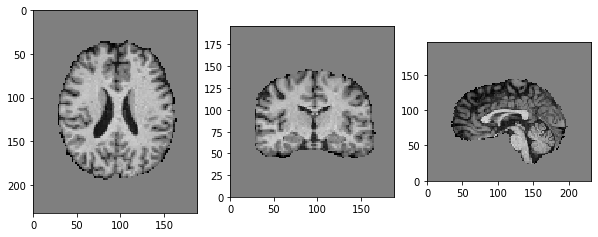

Segmentation


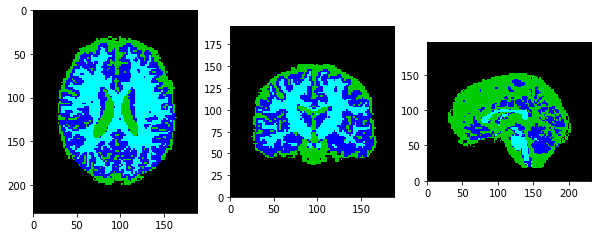

Mask


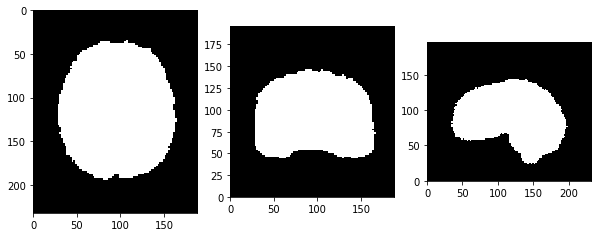

In [18]:
sample = dataset_train.get_sample(0)
img_name = dataset_train.get_img_name(0)
seg_name = dataset_train.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

#### The Model

**TASK:** This is the **key part of task A-1** where you have to design a suitable CNN model for brain segmentation. The simple model provided below works to some degree (it let's you run through the upcoming cells), but it will not perform very well. Use what you learned in the lectures to come up with a good architecture. Start with a simple, shallow model and only increase complexity (e.g., number of layers) if needed.

In [0]:
class SimpleNet3D(nn.Module):

    def __init__(self, num_classes):
        super(SimpleNet3D, self).__init__()
        self.conv1 = nn.Conv3d(1, 4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(4, 8, kernel_size=3, padding=1)
        self.conv3 = nn.Conv3d(8, 4, kernel_size=3, padding=1)
        self.conv4 = nn.Conv3d(4, num_classes, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.conv4(x)
        print("x len is:" + str(x.shape))
        return F.softmax(x, dim=1)

In [0]:
class ModSimpleNet3D(nn.Module):

    def __init__(self, num_classes):
        super(ModSimpleNet3D, self).__init__()
        self.conv1 = nn.Conv3d(1, 4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(4, 8, kernel_size=3, padding=1)
        self.conv3 = nn.Conv3d(8, 16, kernel_size=3, padding=1)
        self.conv4 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
        self.conv5 = nn.Conv3d(32, 16, kernel_size=3, padding=1)
        self.conv6 = nn.Conv3d(16, 8, kernel_size=3, padding=1)
        self.conv7 = nn.Conv3d(8, 4, kernel_size=3, padding=1)
        self.conv8 = nn.Conv3d(4, num_classes, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))

        x = self.conv8(x)
        res =  F.log_softmax(x, dim=1)
        return res

#### TRAINING

Below is an implementation of a full training procedure including a loop for intermediate evaluation of the model on the validation data. Feel free to modify this procedure. For example, in addition to the loss you may want to monitor precision, recall and Dice scores (or others).

START TRAINING...
+ TRAINING 	Epoch: 1 	Loss: 0.272691 	Overall Dice Score: 0.4329363101393425
Dice score for...
CSF: 0.0024152306545275073	GM: 0.7051823373852752	WM: 0.4217913368318064	
--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss: 0.278298 	Overall Dice Score: 0.41601888670695686
Dice score for...
CSF: 0.0016500443841052687	GM: 0.7299118989491562	WM: 0.4063729122727014	


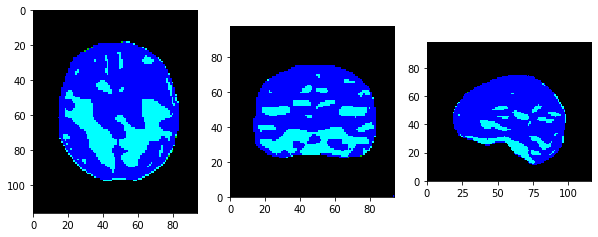

--------------------------------------------------
+ TRAINING 	Epoch: 2 	Loss: 0.248207 	Overall Dice Score: 0.4228474620827644
Dice score for...
CSF: 0.16043990890484014	GM: 0.3600996562490145	WM: 0.8887423830019685	
+ TRAINING 	Epoch: 3 	Loss: 0.210890 	Overall Dice Score: 0.43738185255198486
Dice score for...
CSF: 0.25506236084322026	GM: 0.3439222523670652	WM: 0.9221749366171678	
+ TRAINING 	Epoch: 4 	Loss: 0.218939 	Overall Dice Score: 0.49688758971839136
Dice score for...
CSF: 0.17191115404691604	GM: 0.6062894670371306	WM: 0.7400387919091161	
+ TRAINING 	Epoch: 5 	Loss: 0.204299 	Overall Dice Score: 0.5448229712558552
Dice score for...
CSF: 0.35521613001458496	GM: 0.5270229582235605	WM: 0.7972958452722063	
+ TRAINING 	Epoch: 6 	Loss: 0.230704 	Overall Dice Score: 0.5836002046436697
Dice score for...
CSF: 0.5568382807803229	GM: 0.5041731239613869	WM: 0.7692061536492292	
+ TRAINING 	Epoch: 7 	Loss: 0.193173 	Overall Dice Score: 0.622084552450037
Dice score for...
CSF: 0.564678920983

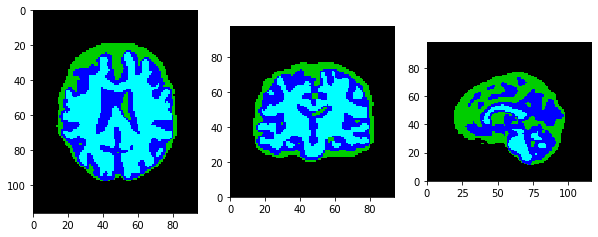

--------------------------------------------------
+ TRAINING 	Epoch: 11 	Loss: 0.160065 	Overall Dice Score: 0.6688484531134092
Dice score for...
CSF: 0.6800927137940502	GM: 0.542976330345474	WM: 0.8790202171018119	
+ TRAINING 	Epoch: 12 	Loss: 0.153266 	Overall Dice Score: 0.6761596105057852
Dice score for...
CSF: 0.8034489379156268	GM: 0.5457231461886143	WM: 0.7781094527363183	
+ TRAINING 	Epoch: 13 	Loss: 0.178464 	Overall Dice Score: 0.6272228298795849
Dice score for...
CSF: 0.5285783066235642	GM: 0.6393943398132963	WM: 0.8933907948465619	
+ TRAINING 	Epoch: 14 	Loss: 0.126791 	Overall Dice Score: 0.7113388193871762
Dice score for...
CSF: 0.5824225453888537	GM: 0.7301670957236198	WM: 0.8435415801097723	
+ TRAINING 	Epoch: 15 	Loss: 0.123596 	Overall Dice Score: 0.7048856334914982
Dice score for...
CSF: 0.6847730128890873	GM: 0.6379336158467918	WM: 0.8412504519647027	
+ TRAINING 	Epoch: 16 	Loss: 0.143267 	Overall Dice Score: 0.6979970713694531
Dice score for...
CSF: 0.561821086261

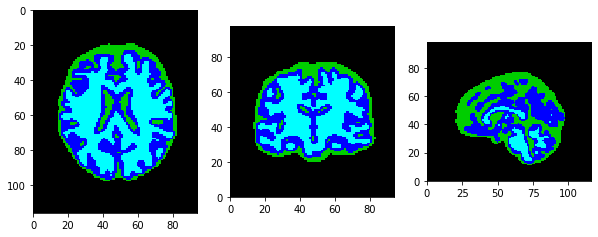

--------------------------------------------------
+ TRAINING 	Epoch: 21 	Loss: 0.111551 	Overall Dice Score: 0.7510095755626826
Dice score for...
CSF: 0.6515881581990595	GM: 0.7622440373781332	WM: 0.890438965724594	
+ TRAINING 	Epoch: 22 	Loss: 0.124663 	Overall Dice Score: 0.7433322800429324
Dice score for...
CSF: 0.6873455585901938	GM: 0.7390060317156942	WM: 0.8395051257858301	
+ TRAINING 	Epoch: 23 	Loss: 0.122994 	Overall Dice Score: 0.7557395877711589
Dice score for...
CSF: 0.7233892608353888	GM: 0.7023221184567673	WM: 0.8799931964111068	
+ TRAINING 	Epoch: 24 	Loss: 0.115707 	Overall Dice Score: 0.736732888828412
Dice score for...
CSF: 0.629887574213651	GM: 0.848252023197143	WM: 0.7580660158066015	
+ TRAINING 	Epoch: 25 	Loss: 0.111412 	Overall Dice Score: 0.7750674886585978
Dice score for...
CSF: 0.8148350252613159	GM: 0.712991154702449	WM: 0.854385934790447	
+ TRAINING 	Epoch: 26 	Loss: 0.167969 	Overall Dice Score: 0.6509238511082371
Dice score for...
CSF: 0.44257241181531404

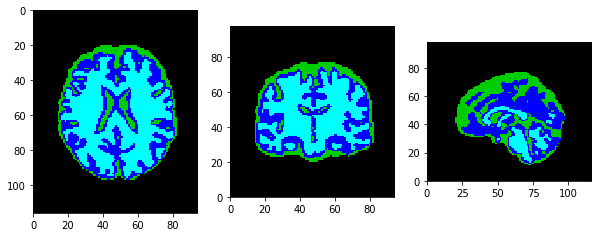

--------------------------------------------------
+ TRAINING 	Epoch: 31 	Loss: 0.094455 	Overall Dice Score: 0.7732156262198601
Dice score for...
CSF: 0.8080322183689451	GM: 0.7409271119243671	WM: 0.8271112216969395	
+ TRAINING 	Epoch: 32 	Loss: 0.115591 	Overall Dice Score: 0.7715133826242174
Dice score for...
CSF: 0.8304048342715321	GM: 0.6677133617659464	WM: 0.8845440783766776	
+ TRAINING 	Epoch: 33 	Loss: 0.116980 	Overall Dice Score: 0.7780764679964157
Dice score for...
CSF: 0.7885401644340703	GM: 0.6909737375811876	WM: 0.9145740521865624	
+ TRAINING 	Epoch: 34 	Loss: 0.127361 	Overall Dice Score: 0.7514196376359832
Dice score for...
CSF: 0.6699845893439103	GM: 0.7380767048827791	WM: 0.9381607618432733	
+ TRAINING 	Epoch: 35 	Loss: 0.091560 	Overall Dice Score: 0.7972731278674926
Dice score for...
CSF: 0.6595136492639403	GM: 0.8636330781614482	WM: 0.8740735932141042	
+ TRAINING 	Epoch: 36 	Loss: 0.143983 	Overall Dice Score: 0.75614961823542
Dice score for...
CSF: 0.6751002741961

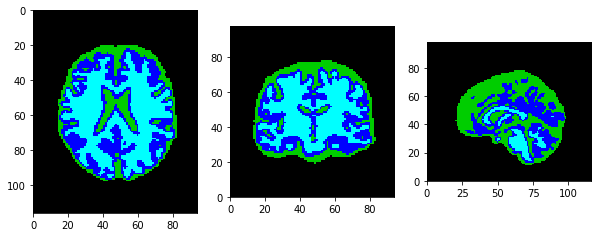

--------------------------------------------------
+ TRAINING 	Epoch: 41 	Loss: 0.100027 	Overall Dice Score: 0.8018005584279085
Dice score for...
CSF: 0.8376665019607019	GM: 0.7630763020234698	WM: 0.9252752200152216	
+ TRAINING 	Epoch: 42 	Loss: 0.087405 	Overall Dice Score: 0.8190227898850374
Dice score for...
CSF: 0.8564473613427295	GM: 0.7980054516196127	WM: 0.8718158289061436	
+ TRAINING 	Epoch: 43 	Loss: 0.120701 	Overall Dice Score: 0.78014907434477
Dice score for...
CSF: 0.6268303953578219	GM: 0.9310537432828921	WM: 0.7678222367691314	
+ TRAINING 	Epoch: 44 	Loss: 0.089499 	Overall Dice Score: 0.8147636072975514
Dice score for...
CSF: 0.8238085048980844	GM: 0.8241564900116213	WM: 0.8183362596687703	
+ TRAINING 	Epoch: 45 	Loss: 0.107254 	Overall Dice Score: 0.8007515358277402
Dice score for...
CSF: 0.8078427667013134	GM: 0.797772371279015	WM: 0.8092699001473779	
+ TRAINING 	Epoch: 46 	Loss: 0.090556 	Overall Dice Score: 0.7859374861423576
Dice score for...
CSF: 0.87911910185047

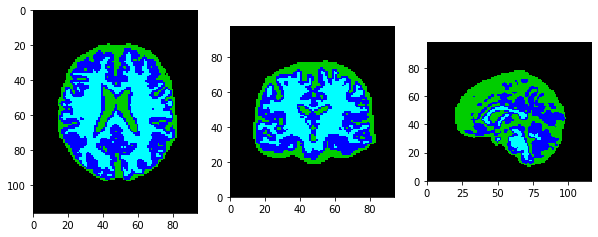

--------------------------------------------------
+ TRAINING 	Epoch: 51 	Loss: 0.091538 	Overall Dice Score: 0.8259420012969924
Dice score for...
CSF: 0.7759646765214053	GM: 0.8963496077287169	WM: 0.8584437409622074	
+ TRAINING 	Epoch: 52 	Loss: 0.088805 	Overall Dice Score: 0.8254741487955309
Dice score for...
CSF: 0.83926697033021	GM: 0.7873309702772479	WM: 0.8839477344139008	
+ TRAINING 	Epoch: 53 	Loss: 0.113860 	Overall Dice Score: 0.7780812931713932
Dice score for...
CSF: 0.8501594477858959	GM: 0.7718843664368595	WM: 0.740768998740219	
+ TRAINING 	Epoch: 54 	Loss: 0.135051 	Overall Dice Score: 0.7794161091319836
Dice score for...
CSF: 0.7621726048006565	GM: 0.7840497199558579	WM: 0.7975047524720843	
+ TRAINING 	Epoch: 55 	Loss: 0.078972 	Overall Dice Score: 0.8378853375567131
Dice score for...
CSF: 0.7801337753280634	GM: 0.8905454177488447	WM: 0.8509610128353705	
+ TRAINING 	Epoch: 56 	Loss: 0.098562 	Overall Dice Score: 0.8156441693902398
Dice score for...
CSF: 0.76338198153901

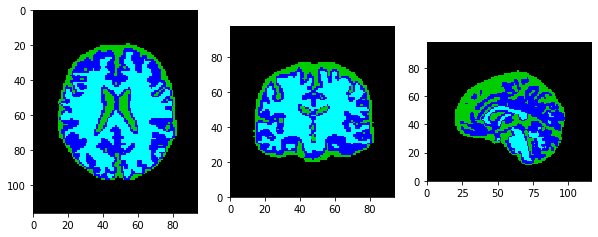

--------------------------------------------------
+ TRAINING 	Epoch: 61 	Loss: 0.166645 	Overall Dice Score: 0.7155247995275191
Dice score for...
CSF: 0.5769473789227477	GM: 0.7543522238367952	WM: 0.9437309093585544	
+ TRAINING 	Epoch: 62 	Loss: 0.142874 	Overall Dice Score: 0.7803062794215464
Dice score for...
CSF: 0.5584490412003863	GM: 0.8713449540104201	WM: 0.9052667951842288	
+ TRAINING 	Epoch: 63 	Loss: 0.114094 	Overall Dice Score: 0.7919032560377274
Dice score for...
CSF: 0.5948685025107192	GM: 0.8999608444755406	WM: 0.8909173561232839	
+ TRAINING 	Epoch: 64 	Loss: 0.104068 	Overall Dice Score: 0.8193018089797316
Dice score for...
CSF: 0.6793021869864374	GM: 0.9060400911113577	WM: 0.8291893083307196	
+ TRAINING 	Epoch: 65 	Loss: 0.076943 	Overall Dice Score: 0.8302574685246124
Dice score for...
CSF: 0.6678897131158438	GM: 0.895487915532459	WM: 0.9102217091907814	
+ TRAINING 	Epoch: 66 	Loss: 0.080455 	Overall Dice Score: 0.8222628420098159
Dice score for...
CSF: 0.869246145841

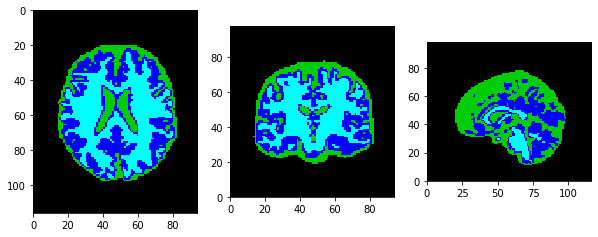

--------------------------------------------------
+ TRAINING 	Epoch: 71 	Loss: 0.067543 	Overall Dice Score: 0.8582493739444412
Dice score for...
CSF: 0.8165646518745218	GM: 0.886755620880509	WM: 0.9020052663560867	
+ TRAINING 	Epoch: 72 	Loss: 0.109454 	Overall Dice Score: 0.8068522717147016
Dice score for...
CSF: 0.7288375816057515	GM: 0.808135720311182	WM: 0.9168525787655437	
+ TRAINING 	Epoch: 73 	Loss: 0.111456 	Overall Dice Score: 0.8311141332344275
Dice score for...
CSF: 0.7626987958752783	GM: 0.9080616119309508	WM: 0.8322860351148558	
+ TRAINING 	Epoch: 74 	Loss: 0.069225 	Overall Dice Score: 0.8519960506344038
Dice score for...
CSF: 0.8293092644686496	GM: 0.8920597658852267	WM: 0.8584876558566269	
+ TRAINING 	Epoch: 75 	Loss: 0.083335 	Overall Dice Score: 0.8312770465557416
Dice score for...
CSF: 0.8759846996795203	GM: 0.8583665373611136	WM: 0.7818725099601593	
+ TRAINING 	Epoch: 76 	Loss: 0.080322 	Overall Dice Score: 0.8424024599008575
Dice score for...
CSF: 0.8063040568883

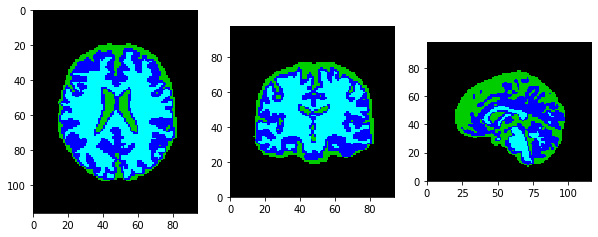

--------------------------------------------------
+ TRAINING 	Epoch: 81 	Loss: 0.078445 	Overall Dice Score: 0.8574810016195341
Dice score for...
CSF: 0.7701419102070568	GM: 0.9067054119600603	WM: 0.8917268363519019	
+ TRAINING 	Epoch: 82 	Loss: 0.082197 	Overall Dice Score: 0.8290165344547452
Dice score for...
CSF: 0.8754980929286036	GM: 0.7910589959692196	WM: 0.897819326601912	
+ TRAINING 	Epoch: 83 	Loss: 0.077484 	Overall Dice Score: 0.8467556225979089
Dice score for...
CSF: 0.875774888848993	GM: 0.8569906522141412	WM: 0.8665730487634933	
+ TRAINING 	Epoch: 84 	Loss: 0.111356 	Overall Dice Score: 0.819825482998879
Dice score for...
CSF: 0.7623456479515333	GM: 0.784332547513846	WM: 0.9160369614178366	
+ TRAINING 	Epoch: 85 	Loss: 0.090233 	Overall Dice Score: 0.8451242275070359
Dice score for...
CSF: 0.8244649949047135	GM: 0.857184672842484	WM: 0.8697628884795991	
+ TRAINING 	Epoch: 86 	Loss: 0.082059 	Overall Dice Score: 0.8262045182351758
Dice score for...
CSF: 0.8739038328899399

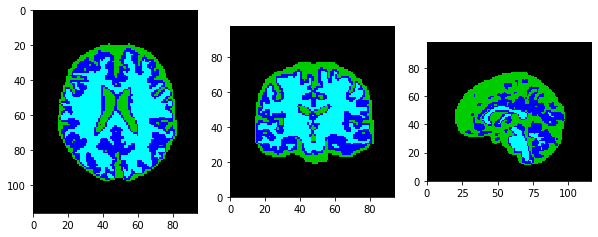

--------------------------------------------------
+ TRAINING 	Epoch: 91 	Loss: 0.114562 	Overall Dice Score: 0.7781382958576893
Dice score for...
CSF: 0.7038782083015439	GM: 0.8153214774281806	WM: 0.9323182388941051	
+ TRAINING 	Epoch: 92 	Loss: 0.073449 	Overall Dice Score: 0.8576629785097081
Dice score for...
CSF: 0.7915867480383608	GM: 0.8966713443727196	WM: 0.877875119293994	
+ TRAINING 	Epoch: 93 	Loss: 0.078822 	Overall Dice Score: 0.8126140981096519
Dice score for...
CSF: 0.8913879557957257	GM: 0.8540464170643878	WM: 0.7327587080045781	
+ TRAINING 	Epoch: 94 	Loss: 0.089088 	Overall Dice Score: 0.8326071940268636
Dice score for...
CSF: 0.8841209553721423	GM: 0.7866453572723975	WM: 0.8732821141172965	
+ TRAINING 	Epoch: 95 	Loss: 0.070440 	Overall Dice Score: 0.8679347340892023
Dice score for...
CSF: 0.8008901469301104	GM: 0.8930903337694344	WM: 0.9411979898723454	
+ TRAINING 	Epoch: 96 	Loss: 0.079160 	Overall Dice Score: 0.846956830892508
Dice score for...
CSF: 0.7673240404156

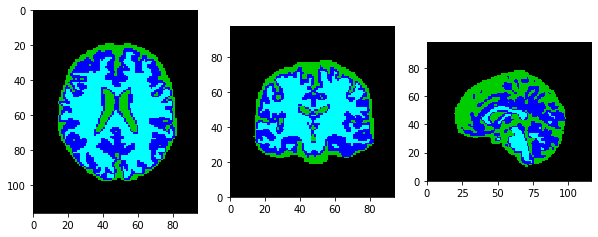

--------------------------------------------------

Finished TRAINING.


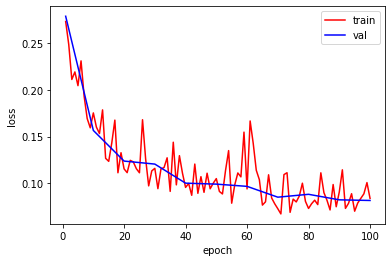

In [21]:
model_dir = os.path.join(out_dir, 'model')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

torch.manual_seed(rnd_seed) #fix random seed

model = ModSimpleNet3D(num_classes=num_classes).to(device)
model.train()
    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_train_log = []
loss_val_log = []
epoch_val_log = []
num_epochs = 100
learning_rate = 0.001
batch_size = 10
matters={
  'CSF': 1,
  'GM': 2,
  'WM': 3
}
def get_dice_score(img, ref, tissue_class):
  check_ref = ref.cpu().squeeze().numpy().astype(np.uint8)
  img_arr = img.cpu().squeeze().numpy().astype(np.uint8)
  
  check_ref[check_ref != tissue_class] = 0
  img_arr[check_ref != tissue_class] = 0

  dice_prd = sitk.GetImageFromArray(img_arr)
  dice_seg = sitk.GetImageFromArray(check_ref)
  overlap_filter = sitk.LabelOverlapMeasuresImageFilter()
  overlap_filter.Execute(dice_prd, dice_seg)
  dice_score = overlap_filter.GetDiceCoefficient()
  return dice_score

print('START TRAINING...')
for epoch in range(1, num_epochs + 1):

    # Training
    for batch_idx, batch_samples in enumerate(dataloader_train):
        img, seg = batch_samples['img'].to(device), batch_samples['seg'].to(device)
        optimizer.zero_grad()
        prd = model(img)
        prd_flat = prd.view(prd.size(0), prd.size(1), -1)
        seg_flat = seg.view(seg.size(0), seg.size(1), -1)

        loss = F.cross_entropy(prd_flat, seg_flat.squeeze(1))
        loss.backward()
        optimizer.step()

    loss_train_log.append(loss.item())
    prd = torch.argmax(prd, dim=1)
    
    # Getting the dice scores for overall
    dice_prd = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
    dice_seg = sitk.GetImageFromArray(seg.cpu().squeeze().numpy().astype(np.uint8))
    overlap_filter = sitk.LabelOverlapMeasuresImageFilter()
    overlap_filter.Execute(dice_prd, dice_seg)
    overall_dice_score = overlap_filter.GetDiceCoefficient()

    print('+ TRAINING \tEpoch: {} \tLoss: {:.6f} \tOverall Dice Score: {}'.format(epoch, loss.item(), overall_dice_score))
    print('Dice score for...')
    for matter, matter_num in matters.items():
         print('{}: {}\t'.format(matter, get_dice_score(prd, seg, matter_num)), end = '')
    print()

    # Validation
    if epoch == 1 or epoch % val_interval == 0:
        loss_val = 0
        sum_pts = 0
        with torch.no_grad():
            for data_sample in dataloader_val:
                img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
                prd = model(img)
                prd_flat = prd.view(prd.size(0), prd.size(1), -1)
                seg_flat = seg.view(seg.size(0), seg.size(1), -1)
                
                loss_val += F.cross_entropy(prd_flat, seg_flat.squeeze(1), reduction='sum').item()
                sum_pts += seg_flat.size(2)
                
        prd = torch.argmax(prd, dim=1)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))

        # Getting the dice scores for overall
        dice_prd = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        dice_seg = sitk.GetImageFromArray(seg.cpu().squeeze().numpy().astype(np.uint8))
        overlap_filter = sitk.LabelOverlapMeasuresImageFilter()
        overlap_filter.Execute(dice_prd, dice_seg)
        overall_dice_score = overlap_filter.GetDiceCoefficient()

        loss_val /= sum_pts

        loss_val_log.append(loss_val)
        epoch_val_log.append(epoch)

        print('--------------------------------------------------')
        #getting dice scores for individual matters
        print('+ VALIDATE \tEpoch: {} \tLoss: {:.6f} \tOverall Dice Score: {}'.format(epoch, loss_val, overall_dice_score))
        print('Dice score for...')
        for matter, matter_num in matters.items():
          print('{}: {}\t'.format(matter, get_dice_score(prd, seg, matter_num)), end = '')
        print()
        display_image(sitk.LabelToRGB(prediction))
        print('--------------------------------------------------')

torch.save(model.state_dict(), os.path.join(model_dir, 'model.pt'))

print('\nFinished TRAINING.')

plt.plot(range(1, num_epochs + 1), loss_train_log, c='r', label='train')
plt.plot(epoch_val_log, loss_val_log, c='b', label='val')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#### Loading and pre-processing of testing data

Now that we have trained a model, the next cells are about applying that model to the 500 subjects that are used for training the age regressor. Note, at a later stage you will also need to run the model on the 100 subjects from the hold-out set, once these have been made available. Before testing on the full set, you may want to initially just test on the 5 validation subjects to check everything is working fine.

In [22]:
meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_reg_train.csv')
ids_seg_test = list(meta_data_reg_train['subject_id'])
meta_data_reg_test = pd.read_csv(data_dir + 'meta/meta_data_reg_test.csv')
ids_seg_test = ids_seg_test + list(meta_data_reg_test['subject_id'])
files_seg_img_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test]
files_seg_seg_test = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test]
files_seg_msk_test = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test]

dataset_test = ImageSegmentationDataset(files_seg_img_test, files_seg_seg_test, files_seg_msk_test, img_spacing, img_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 600/600 [04:21<00:00,  2.20it/s]


#### Visualise testing example

Just to check how a testing image looks like after pre-processing.

Image: sub-CC520745_T1w_unbiased.nii.gz


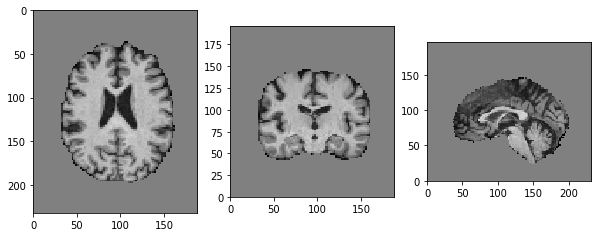

Segmentation


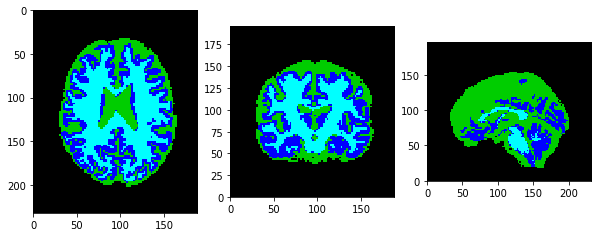

Mask


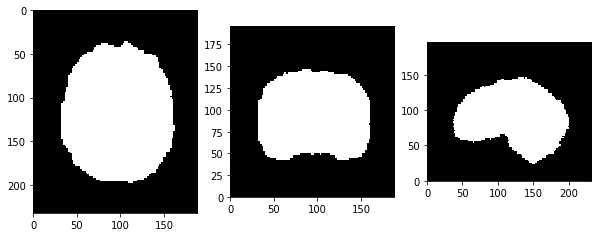

In [23]:
sample = dataset_test.get_sample(0)
img_name = dataset_test.get_img_name(0)
seg_name = dataset_test.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

#### TESTING

Below is an implementation of a full testing procedure that saves the segmentations in an output folder. Feel free to modify this procedure.

**TASK: You will need to add the calculations of Dice scores (and possibly others) to evaluate the segmentation performance.**

START TESTING...


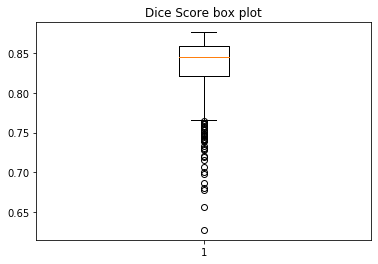

+ TESTING 	Loss: 0.093723, 	Overall Dice Score: 0.8325389050731237
Dice score for...
CSF: 0.7485519087061749	GM: 0.855612550957926	WM: 0.9360821923931625	


Reference segmentation


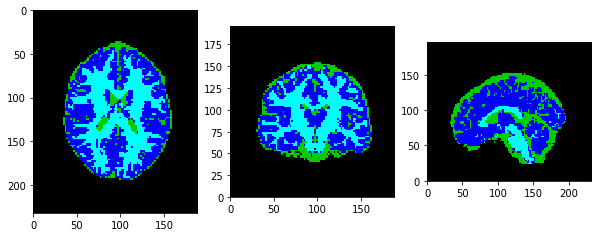

Predicted segmentation


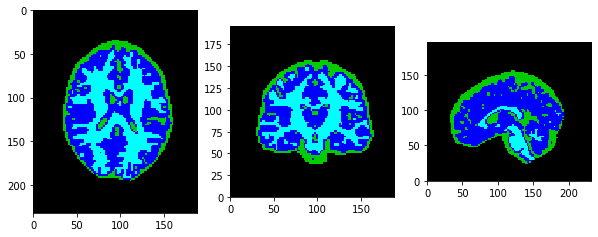


Finished TESTING.


In [24]:
pred_dir = os.path.join(out_dir, 'pred')
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)

model = ModSimpleNet3D(num_classes=num_classes)
model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt')))
model.to(device)
model.eval()
    
print('START TESTING...')

loss_test = 0
sum_pts = 0
idx_test = 0
dice_scores = []
num_epochs = 100
learning_rate = 0.001
batch_size = 10
dice_scores_by_parts = {
  'CSF' : [],
  'GM' : [],
  'WM' : []
}

with torch.no_grad():
    for data_sample in dataloader_test:
        img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
        prd = model(img)
        prd_flat = prd.view(prd.size(0), prd.size(1), -1)
        seg_flat = seg.view(seg.size(0), seg.size(1), -1)
        loss_test += F.cross_entropy(prd_flat, seg_flat.squeeze(1), reduction='sum').item()
        sum_pts += seg_flat.size(2)        
        
        prd = torch.argmax(prd, dim=1)
        dice_prd = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        dice_seg = sitk.GetImageFromArray(seg.cpu().squeeze().numpy().astype(np.uint8))
        overlap_filter = sitk.LabelOverlapMeasuresImageFilter()
        overlap_filter.Execute(dice_prd, dice_seg)
        overall_dice_score = overlap_filter.GetDiceCoefficient()
        dice_scores.append(overall_dice_score)

        for matter, matter_num in matters.items():
            dice_scores_by_parts[matter].append(get_dice_score(prd, seg, matter_num))

        sample = dataset_test.get_sample(idx_test)
        name = dataset_test.get_seg_name(idx_test)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        prediction.CopyInformation(sample['seg'])
        sitk.WriteImage(prediction, os.path.join(pred_dir, name))
        
        idx_test += 1
        

loss_test /= sum_pts
fig1, ax1 = plt.subplots()
ax1.set_title('Dice Score box plot')
ax1.boxplot(dice_scores)
plt.show()

print('+ TESTING \tLoss: {:.6f}, \tOverall Dice Score: {}'.format(loss_test, np.mean(dice_scores)))
print('Dice score for...')
for matter, scores in dice_scores_by_parts.items():
      print('{}: {}\t'.format(matter, np.mean(scores)), end = '')
print()

# Show last testing sample as an example
print('\n\nReference segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Predicted segmentation')
display_image(sitk.LabelToRGB(prediction))

print('\nFinished TESTING.')

### TASK A-2: Feature calculation

Start by calculating the three absolute tissue volumes for each subject. Plot the volumes against the subjects' ages. Taking the absolute volumes of tissues as features, however, might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume. But you might also want to explore using different combinations or even polynomial features.

Implement a function that constructs a big matrix $X$ with a row for each subject and features across the columns. Start with just calculating three simple features of relative tissue volumes for GM, WM and CSF, and compare these to the absolute volumes plotted above.

*Note:* If you are struggling with the previous task on image segmentation, or if you prefer to work on this and the following tasks first, you can continue here using the provided reference segmentations which can be found in a subfolder `segs_refs`.

In [25]:
## CALCULATE ABSOLUTE TISSUE VOLUMES

import os

# USE THIS TO RUN THE CALCULATIONS ON YOUR SEGMENTATONS
seg_dir = './output/pred/'

# USE THIS TO RUN THE CALCULATIONS ON OUR REFERENCE SEGMENTATIONS
#seg_dir = data_dir + 'segs_refs/'

meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_reg_train.csv')
ids_reg_train = list(meta_data_reg_train['subject_id'])
files_reg_seg_train = [seg_dir + 'sub-' + f + '_T1w_seg.nii.gz' for f in ids_reg_train]

# THIS MATRIX WILL STORE THE VOLUMES PER TISSUE CLASS
vols = np.zeros((3,len(files_reg_seg_train)))

for idx, _ in enumerate(tqdm(range(len(files_reg_seg_train)), desc='Calculating Features')):
    
    seg_filename = files_reg_seg_train[idx]
    
    if os.path.exists(seg_filename):
        seg = sitk.ReadImage(seg_filename)
        img_array = sitk.GetArrayFromImage(seg)
        GM = 0
        WM = 0
        CSF = 0
        for cell in img_array.flat:
            if cell == 1:
                CSF += 1
            elif cell == 2:
                GM += 1
            elif cell == 3:
                WM += 1
        vols[0][idx] = CSF
        vols[1][idx] = GM
        vols[2][idx] = WM

Calculating Features:   0%|          | 1/500 [00:04<34:44,  4.18s/it]


KeyboardInterrupt: ignored

Plot features versus age.

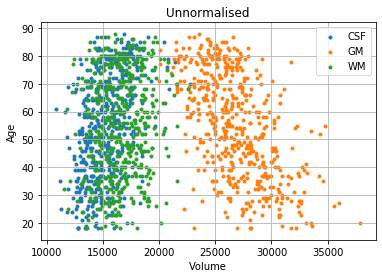

In [0]:
plt.scatter(vols[0,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols[1,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols[2,:],meta_data_reg_train['age'], marker='.')
plt.grid()
plt.title('Unnormalised')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))
plt.show()

In [0]:
## CALCULATE RELATIVE TISSUE VOLUMES

vols_normalised = np.zeros((4,len(files_reg_seg_train)))

for idx, _ in enumerate(tqdm(range(len(files_reg_seg_train)), desc='Calculating Features')):
    CSF = vols[0][idx]
    GM = vols[1][idx]
    WM = vols[2][idx]
    nonBackground = CSF + GM + WM
    vols_normalised[0][idx] = CSF / nonBackground
    vols_normalised[1][idx] = GM / nonBackground
    vols_normalised[2][idx] = WM / nonBackground
    vols_normalised[3][idx] = GM / (WM + CSF)


Calculating Features: 100%|██████████| 500/500 [00:00<00:00, 126708.48it/s]

Plot normalised features versus age.

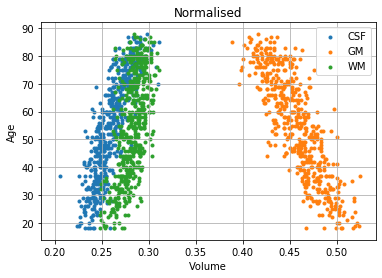

In [0]:
plt.scatter(vols_normalised[0,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols_normalised[1,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols_normalised[2,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols_normalised[3,:],meta_data_reg_train['age'], marker='.')
plt.grid()
plt.title('Normalised')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM','GM/(WM + CSF)'))
plt.show()

Final data for age regression

In [0]:
X = vols_normalised.T
y = meta_data_reg_train['age'].values.reshape(-1,1)

print(X.shape)
print(y.shape)

(500, 3)
(500, 1)


### TASK A-3: Age regression and cross-validation

Experiment with different regression methods from the [scikit-learn toolkit](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning). Remember to construct the output vectur $y$ containing the age for each of the subjects.

Evaluate the methods using two-fold [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) where the dataset of 500 subjects is split into two equally sized sets $(X_1,y_1)$ and $(X_2,y_2)$ which are used for training and testing in an alternating way (so each set is used as $(X_{\text{train}},y_{\text{train}})$ and $(X_{\text{test}},y_{\text{test}})$ exactly once).

Try using at least three different regression methods, and generate a plot allows easy comparison of the performance of the three methods. Useful [error metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics) to report include mean absolute error and r2 score. You might also want to plot the real vs predicted ages.

*Note:* These [scikit-learn examples](https://scikit-learn.org/stable/auto_examples/) might serve as an inspiration.

*Hint:* Be careful how you split the dataset into two folds. Take into account the data characteristics shown at the top of the notebook.

Error calculation and plotting

In [0]:
def plot(y, predicted):
  print('mean absolute error: {0}'.format(mean_absolute_error(y,predicted)))
  print('r2 score: {0}'.format(r2_score(y,predicted)))

  fig, ax = plt.subplots()
  ax.scatter(y, predicted, marker='.')
  ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
  ax.set_xlabel('Real Age')
  ax.set_ylabel('Predicted Age')
  plt.show()

mean absolute error: 10.583069130993358
r2 score: 0.5518905112514486


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


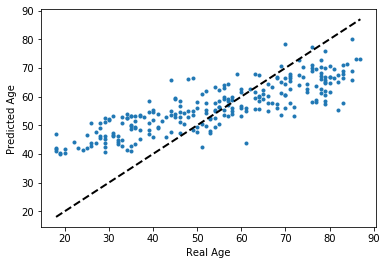

mean absolute error: 16.099527518592165
r2 score: -0.09497487025559215


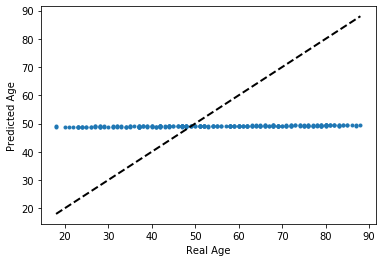

mean age error using Neural Network regression is 13.341298324792762


In [0]:
########################################
# ADD YOUR CODE HERE
########################################

from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import statistics
from sklearn import svm

kf = KFold(n_splits=2)

# NN regression model
est = make_pipeline(MLPRegressor(hidden_layer_sizes=(150, 50, 50, 50 ,10),
                                  learning_rate_init=0.005,
                                  early_stopping=True))
nn_err = 0
for train, test in kf.split(X):
  X_train, y_train, X_test, y_test = X[train], y[train], X[test], y[test]
  y_train = np.reshape(y_train, (1, -1))[0]
  y_test = np.reshape(y_test, (1, -1))[0]

  est.fit(X_train, y_train)
  nn_y_pred = est.predict(X_test)
  nn_err += mean_absolute_error(nn_y_pred, y_test)
  plot(y_test, nn_y_pred)

nn_mean_age_err = nn_err / 2
print("mean age error using Neural Network regression is {}".format(nn_mean_age_err))

mean absolute error: 10.281391748945264
r2 score: 0.5800205787784589


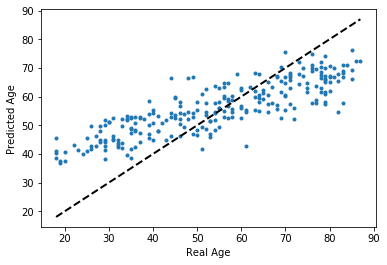

mean absolute error: 9.579016694354156
r2 score: 0.6067703008559786


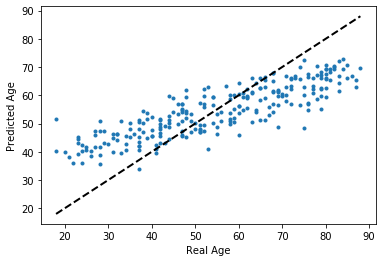

mean age error using support vector regression is 9.93020422164971


In [0]:
# SVR regression model

kf = KFold(n_splits=2)

clf = svm.SVR()
svr_err = 0

for train, test in kf.split(X):
  X_train, y_train, X_test, y_test = X[train], y[train], X[test], y[test]
  y_train = np.reshape(y_train, (1, -1))[0]
  y_test = np.reshape(y_test, (1, -1))[0]
  
  clf.fit(X_train, y_train)
  svr_y_pred = clf.predict(X_test)
  svr_err += mean_absolute_error(svr_y_pred, y_test)
  plot(y_test, svr_y_pred)

svr_mean_age_err = svr_err /2
print("mean age error using support vector regression is {}".format(svr_mean_age_err))

mean absolute error: 7.896539905005091
r2 score: 0.7131999650772118


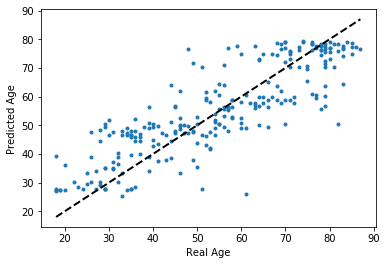

mean absolute error: 7.827286701278353
r2 score: 0.7024008178174876


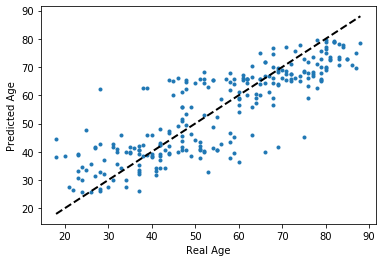

mean age error using decision tree with adaboost regression is 7.861913303141722


In [0]:
#decision tree with adaboost regression model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

kf = KFold(n_splits=2)
rng = np.random.RandomState(1)
# dt_reg = DecisionTreeRegressor(max_depth=4)
ada_reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                          n_estimators=300, random_state=rng)
ensemble_err = 0

for train, test in kf.split(X):
  X_train, y_train, X_test, y_test = X[train], y[train], X[test], y[test]
  y_train = np.reshape(y_train, (1, -1))[0]
  y_test = np.reshape(y_test, (1, -1))[0]
  
  # dt_reg.fit(X_train, y_train)
  ada_reg.fit(X_train, y_train)
  # dt_y_pred = dt_reg.predict(X_test)
  ada_y_pred = ada_reg.predict(X_test)
  ensemble_err += mean_absolute_error(ada_y_pred, y_test)
  plot(y_test, ada_y_pred)

ada_mean_age_err = ensemble_err /2
print("mean age error using decision tree with adaboost regression is {}".format(ada_mean_age_err))

mean absolute error: 8.008
r2 score: 0.7124859539668311


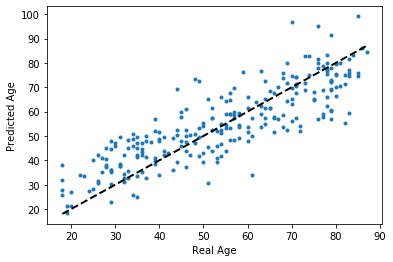

mean absolute error: 7.4145
r2 score: 0.7381319152084709


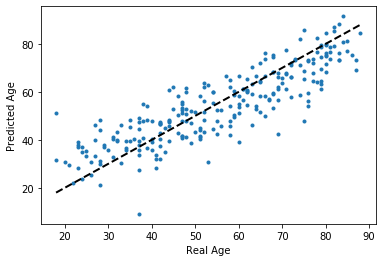

mean age error using linear model regression is 7.71125


In [0]:
from sklearn.linear_model import LinearRegression
regression = LinearRegression()
reg_err = 0
for train, test in kf.split(X):
  X_train, y_train, X_test, y_test = X[train], y[train], X[test], y[test]
 # y_train, y_test = y[train], y[test]
  y_train = np.reshape(y_train, (1, -1))[0]
  y_test = np.reshape(y_test, (1, -1))[0]  
  regression.fit(X_train, y_train)
  reg_y_pred = regression.predict(X_test)
  reg_err += mean_absolute_error(reg_y_pred, y_test)
  plot(y_test, reg_y_pred)
  reg_mean_age_err = reg_err /2
print("mean age error using linear model regression is {}".format(reg_mean_age_err))

## Part B: PCA-based regression using grey matter maps

The second approach will make use of grey matter maps that have been already extracted from the MRI scans and aligned to a common reference space to obtain spatially normalised maps. For this, we have used an advanced, state-of-the-art neuroimaging toolkit, called SPM12. The reference space corresponds to the commonly used MNI atlas as seen in the lecture on image segmentation.

Because these grey matter maps are spatially normalised (ie., registered), voxel locations across images from different subjects roughly correspond to the same anatomical locations. This means that each voxel location in the grey matter maps can be treated as an individual feature. Because those maps are quite large at their full resolution there would be a very large number of features to deal with (more than 850,000). A dimensionality reduction may need to be performed before training a suitable regressor on the low-dimensional feature representation. We will use Principal Component Analysis (PCA) to do the dimensionality reduction. It might also be beneficial to apply some pre-processing (downsampling, smoothing, etc.) before running PCA, which should be explored. The implemented pipeline should be evaluated using two-fold cross-validation using the same data splits as in part A for the 500 subjects, so the two different approaches can be directly compared in terms average age prediction accuracy.

*Note:* For part B, only the spatially normalised grey matter maps should be used.

### TASK B-1: Pre-processing

Before running PCA to reduce the dimensionality of the feature space for grey matter maps, it might be beneficial to run some pre-processing on the maps. In voxel-based analysis where each voxel location is a feature, it is common to apply some smoothing beforehand. This is to reduce noise and to compensate for errors of the spatial normalisation.

Because the maps are quite large, it might also be worthwile to explore whether downsampling could be performed even before PCA. This would further reduce the dimensionality, and might be even needed in the case where PCA on the orignial resolution runs into memory issues. You may want to consider other ways of pre-processing and you can find insipiration in the notebook on medical image computing `02-Intro-Medical-Image-Computing.ipynb`.

Implement a function that performs suitable pre-processing on each grey matter map.

*Hint:* You may want to save the pre-processed maps using `sitk.WriteImage` to avoid recomputation each time you run the notebook.

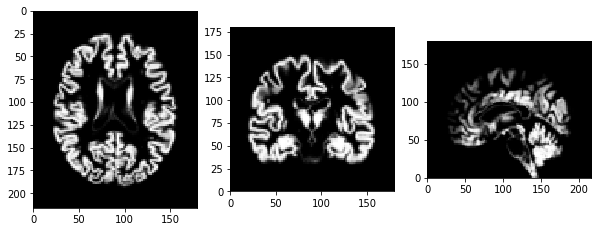

In [0]:
import sklearn
def downsample(img, factor=3):
  smoothed = sitk.DiscreteGaussian(img, (.5 * factor) ** 2)   
  return smoothed[::factor, ::factor, ::factor]

def reshape_to_2d(dataset):
  original_shape = dataset.shape
  return dataset.reshape(original_shape[0], -1), original_shape

def gamma_correction(img, c=10, gamma=3):
    img_array = sitk.GetArrayFromImage(img).astype(float)
    min_value = np.min(img_array)
    max_value = np.max(img_array)
    img_array = (img_array - min_value) / (max_value - min_value)
    img_array = c * np.power(img_array,gamma)
    img_array = img_array * (max_value - min_value) + min_value
    return sitk.GetImageFromArray(img_array)
  
def normalise(arr):
  return arr / np.linalg.norm(arr)

def scale(arr):
  scaler = sklearn.preprocessing.StandardScaler()
  return scaler.fit_transform(arr)

def scale_and_normalise(processed_images):
  processed_images = convert_img_arr_to_numpy(processed_images)
  
  # Normalise and Scale array
  processed_images, old_shape = reshape_to_2d(processed_images)
  processed_images = scale(normalise(processed_images))
  processed_images = processed_images.reshape(old_shape)
  
  return processed_images

def preprocess_image(image):
  processed = gamma_correction(image)
  processed = downsample(processed)
  processed = sitk.DiscreteGaussian(processed)
  return processed

def process_images(image_ids, save_cache=True, load_cached=False):
  filepath_unprocessed = lambda id: data_dir + 'greymatter/wc1sub-' + id + '_T1w.nii.gz'
  filepath_preprocessed = lambda id: data_dir + 'greymatter/wc1sub-' + id + '_processed_T1w.nii.gz'
  filepath_mask = lambda id: data_dir + 'masks/sub-' + id + '_T1w_brain_mask.nii.gz'

  if load_cached:
    return scale_and_normalise([sitk.ReadImage(filepath_preprocessed(id)) for id in image_ids])

  processed_images = []
  for id in image_ids:
    # Read image
    image = sitk.ReadImage(filepath_unprocessed(id))
    
    # Perform image processing
    processed_image = preprocess_image(image)
    
    if save_cache:
      sitk.WriteImage(processed_image, filepath_preprocessed(id))
      
    processed_images.append(processed_image)

  return scale_and_normalise(processed_images)

def convert_img_arr_to_numpy(images):
  return np.array([sitk.GetArrayFromImage(img) for img in images])

def convert_np_arr_to_img(arr):
  return [sitk.GetImageFromArray(numpyarr) for numpyarr in arr]

# Load data 
train_ids = list(meta_data_reg_train['subject_id'])
processed_images = process_images(train_ids)
unprocessed_images = [sitk.ReadImage(data_dir + 'greymatter/wc1sub-' + f + '_T1w.nii.gz') for f in train_ids]

# Display images
img_data = processed_images
gm = unprocessed_images[0]
gmp = processed_images[0]
display_image(gm)

In [0]:
X = img_data
y = meta_data_reg_train['age'].values.reshape(-1,1)

print(img_size)
print(X.shape)
print(y.shape)

[64, 64, 64]
(500, 30, 36, 30)
(500, 1)


### TASK B-2: Dimensionality reduction

Implement dimensionality reduction for grey matter maps using [scitkit-learn's PCA](http://scikit-learn.org/stable/modules/decomposition.html#pca). PCA has an option to set the percentage of variance to be preserved (by setting the parameter `n_components` to a value between 0 and 1). The number of principal modes, that is the new dimensionality of the data, is then automatically determined. Try initially to preserve 95% of the variance (`n_components=0.95`).

*Note:* When dimensionality reduction is used as pre-processing step for supervised learning, as in this case, it is important that PCA is fitted to the training data only, but then applied to both the training and testing data. So make sure your implementation consists of two separate steps, 1) fitting the PCA model to $X_{\text{train}}$ (using the `fit` function), and 2) applying dimensionality reduction to $X_{\text{train}}$ and $X_{\text{test}}$ using the `transform` function.

In [0]:
from sklearn.decomposition import PCA

def apply_PCA(train, test, n_components=0.95):
  pca = PCA(n_components=n_components)
  reshaped_train, original_train = reshape_to_2d(train)
  reshaped_test, original_test = reshape_to_2d(test)
  pca.fit(reshaped_train)
  X_train = pca.transform(reshaped_train)
  X_test = pca.transform(reshaped_test)
  return X_train, X_test, pca

### TASK B-3: Age regression and cross-validation

Experiment with different regression methods from the [scikit-learn toolkit](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning). Evaluate the methods using two-fold [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) in the same way as for your approach in Part A so results can be directly compared. Generate the similar plots.

Try using at least three different regression methods.

*Hint:* Remember, when you use cross-validation where you swap training and testing sets in each fold, you need to fit PCA to the training set of each fold.

In [0]:
import sklearn

# NN regression model
est = make_pipeline(MLPRegressor(hidden_layer_sizes=(150, 50, 50, 50 ,10),
                                  learning_rate_init=0.005,
                                  early_stopping=True))
nn_err = 0
for train, test in kf.split(X):
  X_train, X_test, pca = apply_PCA(X[train], X[test])
  y_train, y_test = y[train], y[test]
  y_train = np.reshape(y_train, (1, -1))[0]
  y_test = np.reshape(y_test, (1, -1))[0]

  est.fit(X_train, y_train)
  nn_y_pred = est.predict(X_test)
  nn_err += mean_absolute_error(nn_y_pred, y_test)
  plot(y_test, nn_y_pred)

nn_mean_age_err = nn_err / 2
print("mean age error using Neural Network regression is {}".format(nn_mean_age_err))

In [0]:
clf = svm.SVR()
svr_err = 0

for train, test in kf.split(X):
  X_train, X_test, pca = apply_PCA(X[train], X[test])
  y_train, y_test = y[train], y[test]
  y_train = np.reshape(y_train, (1, -1))[0]
  y_test = np.reshape(y_test, (1, -1))[0]
  
  clf.fit(X_train, y_train)
  svr_y_pred = clf.predict(X_test)
  svr_err += mean_absolute_error(svr_y_pred, y_test)
  plot(y_test, svr_y_pred)

svr_mean_age_err = svr_err /2
print("mean age error using support vector regression is {}".format(svr_mean_age_err))

In [0]:
rng = np.random.RandomState(1)
# dt_reg = DecisionTreeRegressor(max_depth=4)
ada_reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                          n_estimators=300, random_state=rng)
ensemble_err = 0

for train, test in kf.split(X):
  X_train, X_test, pca = apply_PCA(X[train], X[test])
  y_train, y_test = y[train], y[test]
  y_train = np.reshape(y_train, (1, -1))[0]
  y_test = np.reshape(y_test, (1, -1))[0]
  
  # dt_reg.fit(X_train, y_train)
  ada_reg.fit(X_train, y_train)
  # dt_y_pred = dt_reg.predict(X_test)
  ada_y_pred = ada_reg.predict(X_test)
  ensemble_err += mean_absolute_error(ada_y_pred, y_test)
  plot(y_test, ada_y_pred)

ada_mean_age_err = ensemble_err /2
print("mean age error using decision tree with adaboost regression is {}".format(ada_mean_age_err))

In [0]:
from sklearn import linear_model

regression = linear_model.Lasso(alpha=0.1)

reg_err = 0

for train, test in kf.split(X):
  X_train, X_test, pca = apply_PCA(X[train], X[test])
  y_train, y_test = y[train], y[test]
  y_train = np.reshape(y_train, (1, -1))[0]
  y_test = np.reshape(y_test, (1, -1))[0]
  
  regression.fit(X_train, y_train)
  reg_y_pred = regression.predict(X_test)
  reg_err += mean_absolute_error(reg_y_pred, y_test)
  plot(y_test, reg_y_pred)

reg_mean_age_err = reg_err /2
print("mean age error using lasso regression is {}".format(reg_mean_age_err))

## Part C: CNN-based regression using grey matter maps

The third approach is similar in nature to the second approach in task B, but instead of using PCA for dimensionality reduction in order to use a more classical regression model, now we will use convolutional neural networks (CNNs) on the grey matter maps for predicting the subject's age directly.

You will need to implement a CNN model that takes a grey matter map as an input and maps it to a one-dimensional, real-valued output. A good starting point may be a LeNet-type architecture and adapt the last layers to convert the classification into a regression network. You should have all the necessary ingredients now from above tasks and the notebooks from the lab tutorials for how to set up a CNN model in PyTorch, how to implement a suitable training and testing routine, and how to run a two-fold cross-validation on the 500 subjects similar to tasks A and B.

*Note:* For part C, only the spatially normalised grey matter maps should be used. Similar to task A, you may want to set up a configuration for the CNN training that may also involve some resampling of the input data.

Loading data

In [0]:
meta_data_reg = pd.read_csv(data_dir + 'meta/meta_data_reg_train.csv')
ids_reg = list(meta_data_reg['subject_id'])
files_reg_img_train = [data_dir + 'greymatter/wc1sub-' + f + '_T1w.nii.gz' for f in ids_reg]

In [0]:
class ImageRegressionDataset(Dataset):
    """Dataset for image segmentation."""

    def __init__(self, file_list_img, label_list):
        self.samples = []
        for idx, _ in enumerate(tqdm(range(len(file_list_img)), desc='Loading Data')):
            img_path = file_list_img[idx]

            img = sitk.ReadImage(img_path, sitk.sitkFloat32)

            label = label_list[idx]

            #pre=processing
            img = preprocess_image(img)

            sample = {'img': img, 'age': label}

            self.samples.append(sample)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        sample = self.samples[item]

        image = torch.from_numpy(sitk.GetArrayFromImage(sample['img'])).unsqueeze(0)
        age = sample['age']

        return {'img': image, 'age': age}

In [0]:
# dataset = ImageRegressionDataset(files_reg_img_train, meta_data_reg_train['age'])
# LOAD VALIDATION DATA AS TRAINING FOR QUICK DEBUGGING
#dataset_train = ImageSegmentationDataset(files_seg_img_val, files_seg_seg_val, files_seg_msk_val, img_spacing, img_size)
# dataloader_  train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

# Load data 
# train_ids = list(meta_data_reg_train['subject_id'])
# processed_images = process_images(train_ids)
# unprocessed_images = [sitk.ReadImage(data_dir + 'greymatter/wc1sub-' + f + '_T1w.nii.gz') for f in train_ids]

# Display images
# img_data = processed_images
# gm = unprocessed_images[0]
# gmp = processed_images[0]
# display_image(gm)

In [0]:
from sklearn.model_selection import KFold

In [0]:
X = img_data
y = meta_data_reg_train['age'].values.reshape(-1,1)

print(img_size) #[64, 64, 64]
print(X.shape) # (500, 45, 54, 45)
print(y.shape) # (500, 1)

[64, 64, 64]
(500, 30, 36, 30)
(500, 1)


In [0]:
import torch.nn as nn
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv3d(1, 12, kernel_size=7, padding=0)
        self.batch1 = nn.BatchNorm3d(12)
        self.conv2 = nn.Conv3d(12, 8, kernel_size=7, padding=0)
        self.batch2 = nn.BatchNorm3d(8)
        self.conv3 = nn.Conv3d(120, 30, kernel_size=5, padding=0)
        self.batch3 = nn.BatchNorm3d(30)
        self.conv4 = nn.Conv3d(30, 84, kernel_size=5, padding=2)
        # self.batch4 = nn.BatchNorm3d(84)
        # self.conv5 = nn.Conv3d(84, 78, kernel_size=5, padding=2)
        # self.conv6 = nn.Conv3d(78, 240, kernel_size=5, padding=2)
        # self.conv7 = nn.Conv3d(240, 26, kernel_size=5, padding=2)
        # self.conv8 = nn.Conv3d(26, 82, kernel_size=5, padding=2)
        self.fc1   = nn.Linear(288, 120)
        self.fc2   = nn.Linear(120, 1)
        # self.fc3   = nn.Linear(84, 1)

    def forward(self, x):
        # print("x intial shape is " + str(x.shape))
        x = F.relu(self.conv1(x))
        # print("x shape is " + str(x.shape))

        x = self.batch1(x)
        x = F.max_pool3d(x, 2)
        
        # print("x shape 2 is " + str(x.shape))
        x = F.relu(self.conv2(x))
        # print("x shape 3 is " + str(x.shape))
        x = self.batch2(x)
        x = F.max_pool3d(x, 2)
        # print("x shape 4 is " + str(x.shape))
        # x = F.relu(self.conv3(x))
        # print("x shape 5 is " + str(x.shape))
        # x = self.batch3(x)
        # x = F.relu(self.conv4(x))

        # x = self.batch4(x)
        # x = F.tanh(self.conv5(x))
        # x = F.max_pool3d(x, 2)
        # x = F.relu(self.conv6(x))
        # x = F.relu(self.conv7(x))
        # x = F.relu(self.conv8(x))
        # print("x shape 6 is " + str(x .shape))
        x = x.view(x.size(0), -1)
        # print("x shape 7 is " + str(x.shape))
        x = F.relu(self.fc1(x))
        # print("x shape 8 is " + str(x.shape))
        # x = F.dropout3d(x, 0.2)
        x = self.fc2(x)
        
        # print("x shape 7 is " + str(x.shape))
        # x = self.fc3(x)
        # print("x shape 8 is " + str(x.shape))
        return x


loading dataset

In [0]:

dataset = ImageRegressionDataset(files_reg_img_train, meta_data_reg_train['age'])

Loading Data: 100%|██████████| 500/500 [01:34<00:00,  5.34it/s]


START TRAINING...


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


+ TRAINING 	Epoch: 1 	Loss: 1664.5219082015753
--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss: 500.5651737779379
--------------------------------------------------
+ TRAINING 	Epoch: 2 	Loss: 309.4995533128502
+ TRAINING 	Epoch: 3 	Loss: 123.81251737023145
+ TRAINING 	Epoch: 4 	Loss: 77.20601721710432
+ TRAINING 	Epoch: 5 	Loss: 65.7584955712948
+ TRAINING 	Epoch: 6 	Loss: 54.581150064349174
+ TRAINING 	Epoch: 7 	Loss: 49.25513875428983
+ TRAINING 	Epoch: 8 	Loss: 42.01767650196794
+ TRAINING 	Epoch: 9 	Loss: 30.30451585803018
+ TRAINING 	Epoch: 10 	Loss: 27.190624424638226
--------------------------------------------------
+ VALIDATE 	Epoch: 10 	Loss: 48.72534184560552
--------------------------------------------------
+ TRAINING 	Epoch: 11 	Loss: 19.33199957209459
+ TRAINING 	Epoch: 12 	Loss: 20.49210800142959
+ TRAINING 	Epoch: 13 	Loss: 15.280882760364795
+ TRAINING 	Epoch: 14 	Loss: 11.858297403086326
+ TRAINING 	Epoch: 15 	Loss: 10.102586432128213
+

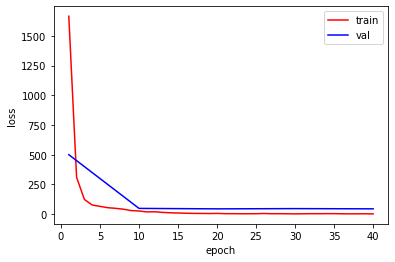

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


+ TRAINING 	Epoch: 1 	Loss: 61.93426761042792
--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss: 82.1527721067639
--------------------------------------------------
+ TRAINING 	Epoch: 2 	Loss: 42.521102335181084
+ TRAINING 	Epoch: 3 	Loss: 30.517154175368137
+ TRAINING 	Epoch: 4 	Loss: 19.83965422374662
+ TRAINING 	Epoch: 5 	Loss: 19.73612399625033
+ TRAINING 	Epoch: 6 	Loss: 12.475325905753765
+ TRAINING 	Epoch: 7 	Loss: 13.10254622516688
+ TRAINING 	Epoch: 8 	Loss: 8.900786117903888
+ TRAINING 	Epoch: 9 	Loss: 6.281834906071483
+ TRAINING 	Epoch: 10 	Loss: 5.267513022875414
--------------------------------------------------
+ VALIDATE 	Epoch: 10 	Loss: 10.91648882077355
--------------------------------------------------
+ TRAINING 	Epoch: 11 	Loss: 4.403589470494539
+ TRAINING 	Epoch: 12 	Loss: 4.273776276073418
+ TRAINING 	Epoch: 13 	Loss: 4.672416725415504
+ TRAINING 	Epoch: 14 	Loss: 2.2694564795490004
+ TRAINING 	Epoch: 15 	Loss: 6.9842692973088125
+ T

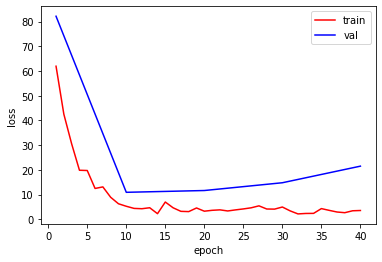

In [0]:
import torch.nn as nn
model_dir = os.path.join(out_dir, 'modelpart3')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

torch.manual_seed(rnd_seed) #fix random seed



learning_rate = 0.0001
num_epochs = 40

# optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate, lr_decay= 0.0001, weight_decay=0.05)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    
print('START TRAINING...')
# X_s, y_s = sklearn.utils.shuffle(X, y)
# split = len(X_s)//2

# X_sets = [X_s[0:split], X_s[split:len(X_s)]]
# y_sets = [y_s[0:split], y_s[split:len(y_s)]]

def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))

# data_train = X_sets[0]
# data_train = data_train[:,None]
# dataloader_train = torch.utils.data.DataLoader(data_train, batch_size=1, shuffle=True)
# expected_train = y_sets[0]

# data_val = X_sets[1]
# expected_val = y_sets[1]
# data_val = data_val[:,None]
# dataloader_val = torch.utils.data.DataLoader(data_val, batch_size=1, shuffle=True)
kf = KFold(n_splits=2)
# for i in range(6):
#   print(dataset[i])

model = LeNet().to(device)
model.train()
for train, test in kf.split(X):
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)
  loss_train_log = []
  loss_val_log = []
  epoch_val_log = []
  
  # print(dataset[0]['img'])
  training_dataset = [dataset[i] for i in train]
  validation_dataset = [dataset[i] for i in test]
  # X_train, y_train, X_test, y_test = X[train], y[train], X[test], y[test]
  # X_train = np.expand_dims(X_train, axis=1)
  # X_test = np.expand_dims(X_test, axis=1) 
  # dataset_train = ImageRegressionDataset(files_reg_img_train, meta_data_reg_train['age'])
  # print(dataset_train[train])
  dataloader_train = torch.utils.data.DataLoader(training_dataset, batch_size=1, shuffle=True)
  dataloader_val = torch.utils.data.DataLoader(validation_dataset, batch_size=1, shuffle=True)
  # expected_train = y_train
  # expected_val = y_test
  for epoch in range(1, num_epochs + 1):

    total_loss = 0
    total_size = 0
    # losses = []

    # Training
    for batch_idx, data in enumerate(dataloader_train):
      # print(data)
      img = data['img'].to(device, dtype=torch.float)
      optimizer.zero_grad()
      prd = model(img)  # (2, 1)
      # print(prd)
      # print("Size of prd: " + str(prd.shape) + "vals: " + str(prd[0, 0]) + "seg" + str(seg[0]))
      # seg_flat = seg.view(seg.size(0), seg.size(1), -1)
      # predicted_flat = torch.tensor([prd[0, 0]])
      expected_flat = data['age'].to(device, dtype=torch.float)
      # print(prd)
      # print(expected_flat)

      # print('predicted: {}, expected: {}'.format(predicted_flat.item(), expected_flat.item()))
      loss = nn.MSELoss()
      output = loss(prd, expected_flat)
      # output.requires_grad = True
      # print(output)
      # print("Loss is: "+ str(output.item()))
      # loss = criterion(prd.cpu().detach().numpy(),seg)
      # print(output.item())
      total_loss += output.item()
      total_size += 1
      output.backward()
      optimizer.step()

    final_loss = total_loss / total_size
    # loss_train_log.append(output.data.cpu().numpy())
    # final_loss = output.data.cpu().numpy()
    loss_train_log.append(final_loss)
    print('+ TRAINING \tEpoch: {} \tLoss: {}'.format(epoch, final_loss))

    # Validation
    if epoch == 1 or epoch % val_interval == 0:
      loss_val = 0
      sum_pts = 0
      total = 0
      with torch.no_grad():
        for batch_idx, data in enumerate(dataloader_val):
          img = data['img'].to(device, dtype=torch.float)
          prd = model(img)
          # print("Size of val prd: " + str(prd.shape) + "vals: " + str(prd[0, 0]) + "seg" + str(seg[0]))
          # predicted_flat = torch.tensor([prd[0, 0]])
          expected_flat = data['age'].to(device, dtype=torch.float)
          loss = nn.MSELoss()
          # print(prd.item())
          loss_val = loss(prd, expected_flat)
          # loss_val.requires_grad = True
          # print(loss_val.item())
          total += loss_val.item()
          # print("Loss val is: "+ str(loss_val.item()))
          sum_pts += 1

      # print("Size of last prd: " + str(prd.shape))
      # prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))

      loss_v = total / sum_pts

      loss_val_log.append(loss_v)
      epoch_val_log.append(epoch)

      print('--------------------------------------------------')
      print('+ VALIDATE \tEpoch: {} \tLoss: {}'.format(epoch, str(loss_v)))
      # display_image(sitk.LabelToRGB(prediction))
      print('--------------------------------------------------')

  print('\nFinished TRAINING.')

  plt.plot(range(1, num_epochs + 1), loss_train_log, c='r', label='train')
  plt.plot(epoch_val_log, loss_val_log, c='b', label='val')
  plt.legend(loc='upper right')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.show()

torch.save(model.state_dict(), os.path.join(model_dir, 'modelpart3.pt'))


**Testing**

loading the test data

In [0]:
meta_data_reg_test = pd.read_csv(data_dir + 'meta/meta_data_reg_test.csv')
ids_reg = list(meta_data_reg_test['subject_id'])
files_reg_img_test = [data_dir + 'greymatter/wc1sub-' + f + '_T1w.nii.gz' for f in ids_reg]
# train_dataset = ImageRegressionDataset(files_reg_img_train, meta_data_reg_train['age'])
test_dataset = ImageRegressionDataset(files_reg_img_test, meta_data_reg_test['age'])

NameError: ignored

Testing

In [0]:
pred_dir = os.path.join(out_dir, 'pred')
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)

model = LeNet()
model.load_state_dict(torch.load(os.path.join(model_dir, 'modelpart3.pt')))
model.to(device)
model.eval()

dataloader_val = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

total_mse = 0
total_mae = 0
sum_pts = 0
total = 0
with torch.no_grad():
  for batch_idx, data in enumerate(dataloader_val):
    img = data['img'].to(device, dtype=torch.float)
    prd = model(img)
    expected_flat = data['age'].to(device, dtype=torch.float)
    # print('prd: {} \texp: {}'.format(prd[0], expected_flat))
    mse_loss = nn.MSELoss()
    mae_loss = nn.L1Loss()
    mse_output = mse_loss(prd[0], expected_flat)
    mae_output = mae_loss(prd[0], expected_flat)
    # print(mse_output.item())
    # print(mae_output.item())
    total_mse += mse_output.item()
    total_mae += mae_output.item()
    sum_pts += 1

# print("Size of last prd: " + str(prd.shape))
# prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))

final_mae = total_mae / sum_pts
final_mse = total_mse / sum_pts

# loss_val_log.append(loss_v)
# epoch_val_log.append(epoch)

print('--------------------------------------------------')
print('+ TESTING \tMSE: {} \tMAE: {}'.format(final_mse, final_mae))
# display_image(sitk.LabelToRGB(prediction))
print('--------------------------------------------------')

--------------------------------------------------
+ TESTING 	MSE: 48.775998446727755 	MAE: 5.52971830368042
--------------------------------------------------


Error calculation and plotting

In [0]:
print('mean absolute error: {0}'.format(mean_absolute_error(y,predicted)))
print('r2 score: {0}'.format(r2_score(y,predicted)))

fig, ax = plt.subplots()
ax.scatter(y, predicted, marker='.')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax.set_xlabel('Real Age')
ax.set_ylabel('Predicted Age')
plt.show()